Imports

In [7]:
import os
import multiprocessing
import rasterio
import tensorflow as tf
from glob import glob
import pickle
import numpy as np
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import keras
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
tf.__version__

'2.4.1'

Test with Simple CNN and Data Loader 

In [9]:
import boto3
import rasterio as rio
import numpy as np
import io

In [10]:
from data_loader import DataLoader

In [11]:
gen = DataLoader(label_file_path_train="labels_test_v1.csv", #or labels.csv
                        label_file_path_val="val_labels.csv",
                        bucket_name='canopy-production-ml',
                        data_extension_type='.tif',
                        training_data_shape=(100, 100, 18),
                        shuffle_and_repeat=False,
                        enable_just_shuffle=True,
                        enable_just_repeat=False,
                        training_data_shuffle_buffer_size=10,
                        data_repeat_count=None,
                        training_data_batch_size=20,
                        normalization_value=255.0,  #normalization TODO double check other channels than RGB 
                        training_data_type=tf.float32,
                        label_data_type=tf.uint8,
                        enable_data_prefetch=False,
                        data_prefetch_size=tf.data.experimental.AUTOTUNE,
                        num_parallel_calls=int(2))
# TODO add data augmentation in DataLoader 

no_of_val_imgs = len(gen.validation_filenames)
no_of_train_imgs = len(gen.training_filenames)
print("Validation on {} images ".format(str(no_of_val_imgs)))
print("Training on {} images ".format(str(no_of_train_imgs)))

Validation on 55 images 
Training on 100 images 


In [12]:
gen

In [6]:
def Simple_CNN(numclasses, input_shape): #TODO use a more complex CNN
        model = Sequential([
            layers.Input(input_shape),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(numclasses)
        ])
        return model

model_simpleCNN = Simple_CNN(10, input_shape=(100, 100, 18))
callbacks_list = []

model_simpleCNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer,etc 

epochs = 10
history = model_simpleCNN.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


Epoch 1/10
5/5 [==============================] - 86s 18s/step - loss: 8.7035 - val_loss: 1.5012
Epoch 2/10
5/5 [==============================] - 81s 17s/step - loss: 1.4694 - val_loss: 0.8578
Epoch 3/10
5/5 [==============================] - 82s 17s/step - loss: 0.6244 - val_loss: 0.2065
Epoch 4/10
5/5 [==============================] - 86s 17s/step - loss: 0.1674 - val_loss: 0.2439
Epoch 5/10
5/5 [==============================] - 84s 17s/step - loss: 0.1836 - val_loss: 0.2107
Epoch 6/10
5/5 [==============================] - 87s 18s/step - loss: 0.1562 - val_loss: 0.1956
Epoch 7/10
5/5 [==============================] - 82s 17s/step - loss: 0.1483 - val_loss: 0.1829
Epoch 8/10
5/5 [==============================] - 83s 17s/step - loss: 0.1326 - val_loss: 0.1831
Epoch 9/10
5/5 [==============================] - 87s 17s/step - loss: 0.1373 - val_loss: 0.1843
Epoch 10/10
5/5 [==============================] - 83s 17s/step - loss: 0.1324 - val_loss: 0.1902


In [18]:
s3 = boto3.resource('s3')
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)

(100, 100, 18)


In [19]:
label_list = ['Habitation', 'ISL', 'Industrial_agriculture', 'Mining',
    'Rainforest', 'River', 'Roads', 'Savannah', 'Shifting_cultivation',
    'Water'
]
# TODO Need to weight labels since they are pretty unbalanced (Rainforest is largely represented)

In [9]:
# s3 = boto3.resource('s3')
# obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/train/58/58_1300_1000.tif")
# obj_bytes = io.BytesIO(obj.get()['Body'].read())
# with rasterio.open(obj_bytes) as src:
#     img_test = np.transpose(src.read(), (1, 2, 0)) / 255
# print(img_test.shape)

In [10]:
predictions = model_simpleCNN.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

This chip was predicted to belong to class Rainforest


In [11]:
print(predictions)
predictions.argsort() 

[[-2020.7277        4.4248075 -1614.4033    -3687.283       157.33759
  -1660.8308     -644.8952    -2039.6393    -1582.1956    -1557.5543   ]]


array([[3, 7, 0, 5, 2, 8, 9, 6, 1, 4]])

In [25]:
model_simpleCNN.evaluate(gen.validation_dataset)

3/3 [==============================] - 35s 10s/step - loss: 0.1902


0.19022126495838165

Resnet50

In [16]:
def Resnet50(numclasses, input_shape):
    model = Sequential()
    model.add(keras.applications.ResNet50(include_top=False, pooling='avg', weights=None, input_shape=input_shape))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(numclasses, activation='softmax'))
    model.layers[0].trainable = True
    return model

In [23]:
model_resnet50 = Resnet50(10, input_shape=(100, 100, 18))
callbacks_list = []

model_resnet50.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
          optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

epochs = 10
history = model_resnet50.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 18 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '


Epoch 1/10
5/5 [==============================] - 100s 19s/step - loss: 0.7197 - val_loss: 0.7552
Epoch 2/10
5/5 [==============================] - 92s 18s/step - loss: 0.7108 - val_loss: 0.7552
Epoch 3/10
5/5 [==============================] - 89s 18s/step - loss: 0.6910 - val_loss: 0.7552
Epoch 4/10
5/5 [==============================] - 92s 18s/step - loss: 0.6992 - val_loss: 0.7552
Epoch 5/10
5/5 [==============================] - 88s 18s/step - loss: 0.6945 - val_loss: 0.7552
Epoch 6/10
5/5 [==============================] - 90s 17s/step - loss: 0.6954 - val_loss: 0.7552
Epoch 7/10
5/5 [==============================] - 91s 18s/step - loss: 0.6927 - val_loss: 0.7552
Epoch 8/10
5/5 [==============================] - 90s 17s/step - loss: 0.6903 - val_loss: 0.7552
Epoch 9/10
5/5 [==============================] - 91s 19s/step - loss: 0.6820 - val_loss: 0.7552
Epoch 10/10
5/5 [==============================] - 94s 18s/step - loss: 0.6781 - val_loss: 0.7552


In [24]:
predictions = model_resnet50.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

This chip was predicted to belong to class Industrial_agriculture


In [25]:
model_resnet50.evaluate(gen.validation_dataset)

3/3 [==============================] - 29s 9s/step - loss: 0.7552


0.7551586031913757

In [26]:
# https://kgptalkie.com/multi-label-image-classification-on-movies-poster-using-cnn/
top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]]) # We need to define a threshold

Industrial_agriculture
Water
Shifting_cultivation


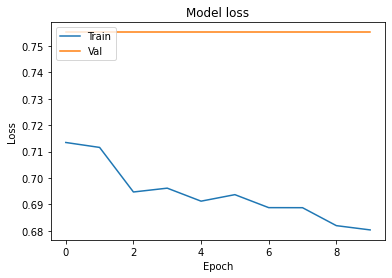

In [28]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
#   plt.plot(history.history['accuracy'])
#   plt.plot(history.history['val_accuracy'])
#   plt.title('Model accuracy')
#   plt.ylabel('Accuracy')
#   plt.xlabel('Epoch')
#   plt.legend(['Train', 'Val'], loc='upper left')
#   plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 20)

In [32]:
def medium_CNN(numclasses, input_shape):
    model = Sequential()
    model.add(Conv2D(16, (3,3), activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Dense(numclasses, activation='sigmoid'))
    return model

In [43]:
model_medium_CNN = medium_CNN(10, input_shape=(100, 100, 18))
callbacks_list = []

model_medium_CNN.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

epochs = 10
history = model_medium_CNN.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


Epoch 1/10
5/5 [==============================] - 86s 17s/step - loss: 0.9270 - accuracy: 0.1209 - val_loss: 0.8956 - val_accuracy: 0.1200
Epoch 2/10
5/5 [==============================] - 91s 19s/step - loss: 0.9144 - accuracy: 0.1223 - val_loss: 0.9091 - val_accuracy: 0.1200
Epoch 3/10
5/5 [==============================] - 85s 17s/step - loss: 0.9159 - accuracy: 0.1198 - val_loss: 0.9205 - val_accuracy: 0.1200
Epoch 4/10
5/5 [==============================] - 86s 18s/step - loss: 0.9162 - accuracy: 0.1193 - val_loss: 0.9494 - val_accuracy: 0.1200
Epoch 5/10
5/5 [==============================] - 84s 17s/step - loss: 0.9036 - accuracy: 0.1200 - val_loss: 0.9662 - val_accuracy: 0.1200
Epoch 6/10
5/5 [==============================] - 85s 17s/step - loss: 0.9077 - accuracy: 0.1201 - val_loss: 0.9763 - val_accuracy: 0.1200
Epoch 7/10
5/5 [==============================] - 89s 17s/step - loss: 0.9053 - accuracy: 0.1200 - val_loss: 0.9755 - val_accuracy: 0.1200
Epoch 8/10
5/5 [===========

In [44]:
predictions = model_medium_CNN.predict(np.array([img_test]))
highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

print("This chip was predicted to belong to top 3 classes:")

top3 = np.argsort(predictions[0])[:-4:-1]
for i in range(3):
  print(label_list[top3[i]])

This chip was predicted to belong to top 3 classes:
Water
Shifting_cultivation
Savannah


In [45]:
model_medium_CNN.evaluate(gen.validation_dataset)

3/3 [==============================] - 32s 11s/step - loss: 0.9204 - accuracy: 0.1200


[0.9204237461090088, 0.12000000476837158]

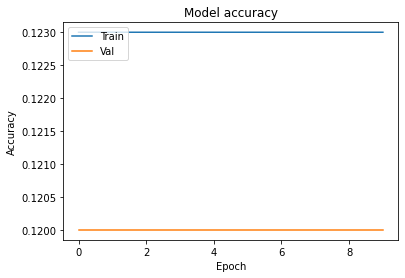

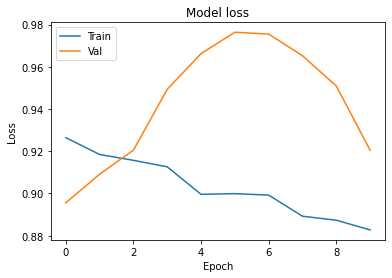

In [52]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, 20)

TEST with bigearthnet-resnet50

In [14]:
import tensorflow_hub as hub
IMAGE_SIZE = (100,100)
num_classes = 10
model_handle = "https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1"
model_bigearthnet = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    # reshape? 
    hub.KerasLayer(model_handle, trainable=False, input_shape=IMAGE_SIZE + (3,)),
#     (model.layers[-1].output)
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_bigearthnet.build((None,)+IMAGE_SIZE+(4,))
model_bigearthnet.summary()

ValueError: in user code:

    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow_hub/keras_layer.py:228 call  *
        result = f()
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1669 __call__  **
        return self._call_impl(args, kwargs)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/wrap_function.py:246 _call_impl
        return super(WrappedFunction, self)._call_impl(
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1687 _call_impl
        return self._call_with_flat_signature(args, kwargs, cancellation_manager)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1736 _call_with_flat_signature
        return self._call_flat(args, self.captured_inputs, cancellation_manager)
    /usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/function.py:1900 _call_flat
        raise ValueError(

    ValueError: The argument 'images' (value Tensor("Placeholder:0", shape=(None, 100, 100, 4), dtype=float32)) is not compatible with the shape this function was traced with. Expected shape (None, None, None, 3), but got shape (None, 100, 100, 4).
    
    If you called get_concrete_function, you may need to pass a tf.TensorSpec(..., shape=...) with a less specific shape, having None on axes which can vary.


In [23]:
# model_bigearthnet.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#           optimizer=keras.optimizers.Adam()) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 

# epochs = 10
# history = model_bigearthnet.fit(gen.training_dataset, validation_data=gen.validation_dataset, epochs=epochs)


In [ ]:
# predictions = model_resnet50.predict(np.array([img_test]))
# highest_score_predictions = np.argmax(predictions) # TODO: read more about multi classes PER IMAGE classification, what is the threshold?

# print("This chip was predicted to belong to class {}".format(label_list[highest_score_predictions]))

# Preproduction Candidate: ResNet50 pretrained on ImageNet

In [36]:
gen = DataLoader(label_file_path_train="labels_test_v1.csv", #or labels.csv
                        label_file_path_val="val_labels.csv",
                        bucket_name='canopy-production-ml',
                        data_extension_type='.tif',
                        training_data_shape=(100, 100, 18),
                        shuffle_and_repeat=False,
                        enable_just_shuffle=False,
                        enable_just_repeat=False,
                        training_data_shuffle_buffer_size=10,
                        data_repeat_count=None,
                        training_data_batch_size=20,
                        normalization_value=255.0,  #normalization TODO double check other channels than RGB 
                        training_data_type=tf.float32,
                        label_data_type=tf.uint8,
                        enable_data_prefetch=False,
                        data_prefetch_size=tf.data.experimental.AUTOTUNE,
                        num_parallel_calls=int(2))
# TODO add data augmentation in DataLoader 

no_of_val_imgs = len(gen.validation_filenames)
no_of_train_imgs = len(gen.training_filenames)
print("Validation on {} images ".format(str(no_of_val_imgs)))
print("Training on {} images ".format(str(no_of_train_imgs)))

Validation on 55 images 
Training on 100 images 


In [37]:
def define_model(numclasses,input_shape):
    # parameters for CNN
    input_tensor = Input(shape=input_shape)

    # introduce a additional layer to get from bands to 3 input channels
    input_tensor = Conv2D(3, (1, 1))(input_tensor)

    base_model_resnet50 = keras.applications.ResNet50(include_top=False,
                              weights='imagenet',
                              input_shape=(100, 100, 3))
    base_model = keras.applications.ResNet50(include_top=False,
                     weights=None,
                     input_tensor=input_tensor)

    for i, layer in enumerate(base_model_resnet50.layers):
        # we must skip input layer, which has no weights
        if i == 0:
            continue
        base_model.layers[i+1].set_weights(layer.get_weights())

    # add a global spatial average pooling layer
    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)

    # let's add a fully-connected layer
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
    # and a logistic layer
    predictions = Dense(numclasses, activation='softmax')(top_model)

    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    model.summary()
    return model

In [38]:
random_id = 1234 #TODO
checkpoint_file = 'checkpoint_{}.h5'.format(random_id)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath= checkpoint_file,
  format='h5',
  verbose=1,
  save_weights_only=True,
  monitor='val_loss',
  mode='min',
  save_best_only=True)

reducelronplateau = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss', factor=0.1, patience=10, verbose=1,
  mode='min', min_lr=1e-10)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=20, verbose=1)

callbacks_list = [model_checkpoint_callback, reducelronplateau, early_stop]

model = define_model(10, (100,100,18))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                          optimizer=keras.optimizers.Adam(),
                          metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]) #TODO add callbacks to save checkpoints and maybe lr reducer, earlystop,etc 


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100, 100, 18 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 3)  57          input_3[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
____________________________________________________________________________________________

In [39]:
epochs = 20
history = model.fit(gen.training_dataset, validation_data=gen.validation_dataset, 
                    epochs=epochs, 
                    callbacks=callbacks_list)


Epoch 1/20
5/5 [==============================] - 39s 6s/step - loss: 0.7017 - accuracy: 0.9058 - val_loss: 0.6661 - val_accuracy: 0.9473

Epoch 00001: val_loss improved from inf to 0.66607, saving model to checkpoint_1234.h5
Epoch 2/20
5/5 [==============================] - 27s 5s/step - loss: 0.6775 - accuracy: 0.9348 - val_loss: 0.6661 - val_accuracy: 0.9473

Epoch 00002: val_loss did not improve from 0.66607
Epoch 3/20
5/5 [==============================] - 26s 5s/step - loss: 0.6775 - accuracy: 0.9348 - val_loss: 0.6661 - val_accuracy: 0.9473

Epoch 00003: val_loss did not improve from 0.66607
Epoch 4/20
5/5 [==============================] - 27s 5s/step - loss: 0.6775 - accuracy: 0.9348 - val_loss: 0.6661 - val_accuracy: 0.9473

Epoch 00004: val_loss did not improve from 0.66607
Epoch 5/20
5/5 [==============================] - 27s 6s/step - loss: 0.6775 - accuracy: 0.9348 - val_loss: 0.6661 - val_accuracy: 0.9473

Epoch 00005: val_loss did not improve from 0.66607
Epoch 6/20
5/5

# Evaluation

In [16]:
model.evaluate(gen.validation_dataset) 

3/3 [==============================] - 9s 3s/step - loss: 0.6661 - accuracy: 0.9473


[0.6660677194595337, 0.9472727179527283]

# Sandbox

In [17]:
# Applying albumentations

In [21]:
help(gen.training_dataset)

Help on BatchDataset in module tensorflow.python.data.ops.dataset_ops object:

class BatchDataset(UnaryDataset)
 |  BatchDataset(input_dataset, batch_size, drop_remainder)
 |  
 |  A `Dataset` that batches contiguous elements from its input.
 |  
 |  Method resolution order:
 |      BatchDataset
 |      UnaryDataset
 |      DatasetV2
 |      collections.abc.Iterable
 |      tensorflow.python.training.tracking.base.Trackable
 |      tensorflow.python.framework.composite_tensor.CompositeTensor
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_dataset, batch_size, drop_remainder)
 |      See `Dataset.batch()` for details.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  element_spec
 |      The type specification of an element of this dataset.
 |      
 |      >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
 |      >>> dataset.element_spec
 |      TensorSpec(shape=(), 

In [24]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

ModuleNotFoundError: No module named 'albumentations'

In [27]:
s3 = boto3.resource('s3')
# TODO test on entire test dataset
obj = s3.Object('canopy-production-ml', "chips/cloudfree-merge-polygons/split/test/100/100_1000_1000.tif")
obj_bytes = io.BytesIO(obj.get()['Body'].read())
with rasterio.open(obj_bytes) as src:
    img_test = np.transpose(src.read(), (1, 2, 0))
print(img_test.shape)

(100, 100, 18)


In [30]:
train_img = tf.image.convert_image_dtype(img_test,tf.float32)

In [34]:
train_img = tf.image.random_flip_left_right(train_img)

In [35]:
help(tf.image)

Help on package tensorflow._api.v2.image in tensorflow._api.v2:

NAME
    tensorflow._api.v2.image - Image ops.

DESCRIPTION
    The `tf.image` module contains various functions for image
    processing and decoding-encoding Ops.
    
    Many of the encoding/decoding functions are also available in the
    core `tf.io` module.
    
    ## Image processing
    
    ### Resizing
    
    The resizing Ops accept input images as tensors of several types. They always
    output resized images as float32 tensors.
    
    The convenience function `tf.image.resize` supports both 4-D
    and 3-D tensors as input and output.  4-D tensors are for batches of images,
    3-D tensors for individual images.
    
    Resized images will be distorted if their original aspect ratio is not the
    same as size. To avoid distortions see tf.image.resize_with_pad.
    
    *   `tf.image.resize`
    *   `tf.image.resize_with_pad`
    *   `tf.image.resize_with_crop_or_pad`
    
    The Class `tf.image.Resiz